In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, Activation, UpSampling1D
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D
from keras import  backend as K

In [2]:
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/AI_study/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/AI_study/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX, testX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX

In [6]:
trainX, testX = scale_data(trainX, testX)

In [7]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [10]:
class_breakdown(y_train)

Class=1, total=870, percentage=16.906
Class=2, total=754, percentage=14.652
Class=3, total=670, percentage=13.020
Class=4, total=900, percentage=17.489
Class=5, total=964, percentage=18.733
Class=6, total=988, percentage=19.199


In [11]:
class_breakdown(y_val)

Class=1, total=356, percentage=16.138
Class=2, total=319, percentage=14.461
Class=3, total=316, percentage=14.325
Class=4, total=386, percentage=17.498
Class=5, total=410, percentage=18.586
Class=6, total=419, percentage=18.994


In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]
n_timesteps, n_features, n_outputs

(128, 9, 6)

In [13]:
def conv_block(in_x, nb_filter, kernel_size):

    x = Conv1D(nb_filter, kernel_size, padding='same')(in_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [14]:
def convolutional_block(in_x, nb_filters, stride):

    F1, F2, F3 = nb_filters

    x = in_x

    x = Conv1D(F1, 3, strides=stride,  padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F2, 3, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F3, 1, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    #----------------------------------------------

    x1 = Conv1D(F3, 1, strides=stride, padding='same', kernel_initializer="he_normal")(in_x)
    x1 = BatchNormalization()(x1)

    x = add([x, x1])
    x = Activation('relu')(x)

    return x

Attention layer는 CNN에서 이미지의 특정 부분에 집중하여 모델이 해당 부분을 더 잘 이해하고 활용할 수 있도록 도와줌. 모델은 이미지의 중요한 특성을 감지하고 강조할 수 있다.

In [15]:
def attention_branch(in_x, nb_filter, kernel_size):

    x1 = conv_block(in_x, nb_filter, kernel_size)
    x = MaxPooling1D(2)(x1)

    x = conv_block(x, nb_filter, kernel_size)
    x = UpSampling1D(size = 2)(x)

    x2 = conv_block(x, nb_filter, kernel_size)
# k.int_shape 함수는 텐서의 크기를 나타냄
    if(K.int_shape(x1)!=K.int_shape(x2)):
        x2 = ZeroPadding1D(1)(x2)
        # zeropadding은 0의 패딩을 사용하여 양쪽에 0 데이터 하나씩 추가
        x2 = Cropping1D((1,0))(x2)
        # Crooping1D는 양쪽에서 1개의 요소를 잘라냄.
    x = add([x1, x2])

    x = conv_block(x, nb_filter, kernel_size)

    x = Conv1D(nb_filter, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    return x

In [16]:
#Residual-Based Temporal Attention Block

def RTA_block(in_x, nb_filter, kernel_size):

    x1 = conv_block(in_x, nb_filter, kernel_size)
    x2 = conv_block(x1, nb_filter, kernel_size)

    attention_map = attention_branch(x1, nb_filter, kernel_size)

    x = multiply([x2, attention_map])
    # multiply 층은 입력받는 두 요소를 같은 위치의 데이터를 곱함
    # ResNET 구조에서 shortcut connection에 사용된다,
    x = add([x, x1])

    out = conv_block(x, nb_filter, kernel_size)

    return out

In [17]:
def RTA_CNN():

    inputs = Input(shape=(n_timesteps,n_features))
    # input shape는 (none, 128, 9)


    # RTA_block(이전 층, 필터 개수, 필터 크기)
    x = RTA_block(inputs, 64, 32)
    # (none, 128, 16)
    x = MaxPooling1D(2)(x)
    # (none, 64, 16)

    x = RTA_block(x, 64, 32)
    # (none, 64, 16)
    x = MaxPooling1D(2)(x)
    # (none, 32, 16)

    #x = RTA_block(x, 16, 32)
    # (none, 32, 16)
    #x = MaxPooling1D(2)(x)

    x = Dropout(0.6)(x)

    x = Flatten()(x)
    #x = Dropout(0.7)(x)
    x = Dense(100,  activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = keras.Model(inputs, x)

    return model

In [18]:
model = RTA_CNN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 64)      18496       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 64)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [20]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 67s 1s/step - loss: 0.8248 - accuracy: 0.6877 - val_loss: 1.7730 - val_accuracy: 0.7180
Epoch 2/100
58/58 [==============================] - 72s 1s/step - loss: 0.2176 - accuracy: 0.9208 - val_loss: 0.3848 - val_accuracy: 0.8885
Epoch 3/100
58/58 [==============================] - 127s 2s/step - loss: 0.1896 - accuracy: 0.9325 - val_loss: 0.1670 - val_accuracy: 0.9456
Epoch 4/100
58/58 [==============================] - 129s 2s/step - loss: 0.1484 - accuracy: 0.9387 - val_loss: 0.1286 - val_accuracy: 0.9529
Epoch 5/100
58/58 [==============================] - 129s 2s/step - loss: 0.1654 - accuracy: 0.9370 - val_loss: 0.1657 - val_accuracy: 0.9433
Epoch 6/100
58/58 [==============================] - 135s 2s/step - loss: 0.1706 - accuracy: 0.9327 - val_loss: 0.1913 - val_accuracy: 0.9451
Epoch 7/100
58/58 [==============================] - 124s 2s/step - loss: 0.1382 - accuracy: 0.9408 - val_loss: 0.1410 - val_accuracy: 0.9479
Epoch 8/

58/58 [==============================] - 105s 2s/step - loss: 0.0661 - accuracy: 0.9690 - val_loss: 0.0439 - val_accuracy: 0.9805
Epoch 59/100
58/58 [==============================] - 106s 2s/step - loss: 0.0701 - accuracy: 0.9682 - val_loss: 0.0802 - val_accuracy: 0.9642
Epoch 60/100
58/58 [==============================] - 107s 2s/step - loss: 0.0785 - accuracy: 0.9652 - val_loss: 0.0541 - val_accuracy: 0.9733
Epoch 61/100
58/58 [==============================] - 105s 2s/step - loss: 0.0911 - accuracy: 0.9608 - val_loss: 0.0809 - val_accuracy: 0.9642
Epoch 62/100
58/58 [==============================] - 105s 2s/step - loss: 0.0803 - accuracy: 0.9644 - val_loss: 0.0643 - val_accuracy: 0.9687
Epoch 63/100
58/58 [==============================] - 107s 2s/step - loss: 0.0798 - accuracy: 0.9650 - val_loss: 0.0586 - val_accuracy: 0.9760
Epoch 64/100
58/58 [==============================] - 104s 2s/step - loss: 0.0808 - accuracy: 0.9641 - val_loss: 0.0578 - val_accuracy: 0.9714
Epoch 65/100

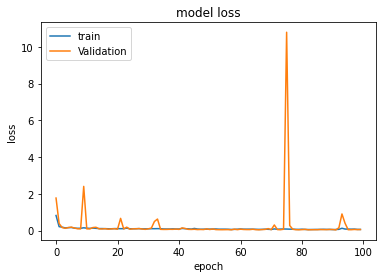

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

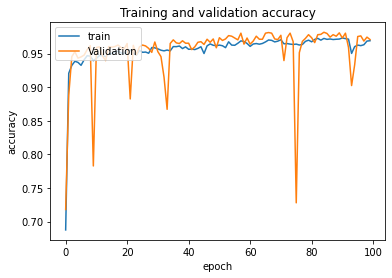

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

[[470   0  26   0   0   0]
 [  7 447  14   3   0   0]
 [  0   0 420   0   0   0]
 [  0   1   0 438  52   0]
 [  0   0   0 115 417   0]
 [  0   0   0   0   0 537]]
0.9260264675941635
0.9261373700880917
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       1.00      0.95      0.97       471
           2       0.91      1.00      0.95       420
           3       0.79      0.89      0.84       491
           4       0.89      0.78      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<AxesSubplot:>

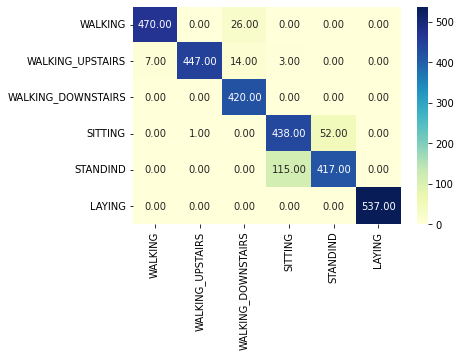

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [24]:
# SE block은 채널 마다 가중치를 주어 합성곱을 수행
# 채널 간의 의존성을 고려하여 효과적인 특성 강조를 수행하는 방법 동입
# squeeze : Global average pooling을 사용하여 채널별로 평균값을 계산하여 각 채널의 중요도를 파악한다.
# excitation : Fully connected layer , 활성화함수를 통해서 각 채널의 가중치 조정, 채널 같의 관계 모델링
def se_block(in_x, nb_filter):
        # GAP층 사용하여 (특징 맵에서 각 채널의 평균으로 축소)
        squeeze = GlobalAveragePooling1D()(in_x)
        # flatten 층 없이 cnn의 특성 맵을 직접 dense층에 입력 -> 공간 정보를 유지한 채로 전달한다.
        excitation = Dense(units=nb_filter // 2)(squeeze)
        # 필터의 개수는 입력 -> 출력에서 얼마다 다운샘플링 하는지 비율을 뜻한다.
        excitation = Activation('relu')(excitation)
        excitation = Dense(units=nb_filter)(excitation)
        excitation = Activation('sigmoid')(excitation)
        excitation = Reshape((1,nb_filter))(excitation)
        # 처음 필터의 개수 ( 채널 수)로 reshape하여 각 채널의 중요도(가중치)를 채널에 곱하는 연산을 수행
        scale = multiply([in_x,excitation])
        out = add([in_x, scale])

        return out

In [25]:
def SENET():

    inputs = Input(shape=(n_timesteps,n_features))
    # (none, 128, 9)
    x = Conv1D(16, 32, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 16)
    x = MaxPooling1D(4)(x)

    x = Conv1D(32, 16, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 32)
    x = MaxPooling1D(4)(x)

    #x = Conv1D(64, 9, padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = se_block(x, 64)
    #x = MaxPooling1D(2)(x)

    #x = Conv1D(64, 9, padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = se_block(x, 64)
    #x = MaxPooling1D(2)(x)

    #x = Conv1D(128, 3, padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = se_block(x, 128)
    #x = MaxPooling1D(2)(x)

    #x = Conv1D(128, 3, padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = se_block(x, 128)
    #x = MaxPooling1D(2)(x)

    x = Flatten()(x)
    x = Dense(300,  activation='relu')(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = keras.Model(inputs, x)

    return model

In [26]:
model = SENET()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 128, 16)      4624        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 128, 16)      64          conv1d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 128, 16)      0           batch_normalization_16[0][0]     
____________________________________________________________________________________________

In [27]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [28]:
# validation_split = 0.1
batch_size = 32

train_epochs = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
230/230 [==============================] - 7s 20ms/step - loss: 0.2538 - accuracy: 0.8980 - val_loss: 0.1246 - val_accuracy: 0.9529
Epoch 2/100
230/230 [==============================] - 4s 17ms/step - loss: 0.1495 - accuracy: 0.9433 - val_loss: 0.1186 - val_accuracy: 0.9574
Epoch 3/100
230/230 [==============================] - 4s 18ms/step - loss: 0.1273 - accuracy: 0.9483 - val_loss: 0.1065 - val_accuracy: 0.9587
Epoch 4/100
230/230 [==============================] - 4s 18ms/step - loss: 0.1179 - accuracy: 0.9478 - val_loss: 0.1099 - val_accuracy: 0.9465
Epoch 5/100
230/230 [==============================] - 4s 18ms/step - loss: 0.1372 - accuracy: 0.9457 - val_loss: 0.1043 - val_accuracy: 0.9560
Epoch 6/100
230/230 [==============================] - 4s 18ms/step - loss: 0.1138 - accuracy: 0.9528 - val_loss: 0.0981 - val_accuracy: 0.9560
Epoch 7/100
230/230 [==============================] - 4s 17ms/step - loss: 0.1107 - accuracy: 0.9513 - val_loss: 0.0951 - val_accuracy:

230/230 [==============================] - 4s 17ms/step - loss: 0.0468 - accuracy: 0.9833 - val_loss: 0.0293 - val_accuracy: 0.9873
Epoch 58/100
230/230 [==============================] - 4s 18ms/step - loss: 0.0501 - accuracy: 0.9801 - val_loss: 0.0322 - val_accuracy: 0.9878
Epoch 59/100
230/230 [==============================] - 4s 17ms/step - loss: 0.0388 - accuracy: 0.9839 - val_loss: 0.0327 - val_accuracy: 0.9900
Epoch 60/100
230/230 [==============================] - 4s 18ms/step - loss: 0.0357 - accuracy: 0.9850 - val_loss: 0.0228 - val_accuracy: 0.9955
Epoch 61/100
230/230 [==============================] - 4s 18ms/step - loss: 0.0377 - accuracy: 0.9848 - val_loss: 0.0239 - val_accuracy: 0.9918
Epoch 62/100
230/230 [==============================] - 4s 19ms/step - loss: 0.0384 - accuracy: 0.9859 - val_loss: 0.0266 - val_accuracy: 0.9932
Epoch 63/100
230/230 [==============================] - 4s 18ms/step - loss: 0.0337 - accuracy: 0.9874 - val_loss: 0.0221 - val_accuracy: 0.990

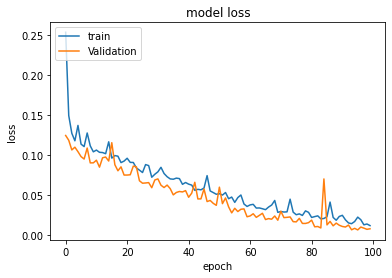

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

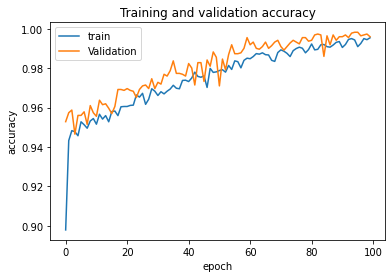

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

[[472   3  17   4   0   0]
 [  0 468   2   1   0   0]
 [  0   2 409   9   0   0]
 [  0   0   0 374 109   8]
 [  0   0   0  20 512   0]
 [  0   0   0   0   0 537]]
0.9406175771971497
0.9399016852702605
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       496
           1       0.99      0.99      0.99       471
           2       0.96      0.97      0.96       420
           3       0.92      0.76      0.83       491
           4       0.82      0.96      0.89       532
           5       0.99      1.00      0.99       537

    accuracy                           0.94      2947
   macro avg       0.95      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<AxesSubplot:>

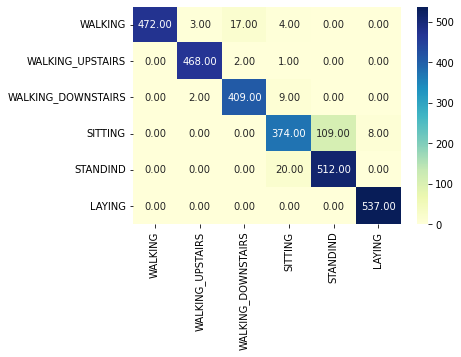

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [32]:
def identity_block(in_x, nb_filters):
    """
    Implementation of the identity block.

    Arguments:
    in_x -- input tensor of shape (batch_size, time_steps, input_dim)
    nb_filters -- list of integers, defining the number of filters in the three Conv1D layers

    Returns:
    x -- output of the identity block, tensor of shape (batch_size, time_steps, nb_filters[2])
    """

    F1, F2, F3 = nb_filters

    x = in_x

    # First convolutional layer
    x = Conv1D(F1, 3, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv1D(F2, 3, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third convolutional layer
    x = Conv1D(F3, 1, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    # Add the input tensor to the output (identity shortcut)
    x = add([x, in_x])
    x = Activation('relu')(x)

    return x

In [33]:
def RESNET50():

    inputs = Input(shape=(n_timesteps,n_features))

    filter_num = 64

    x = Conv1D(filter_num, 3, strides=2, kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(3, strides=2)(x)

    x = convolutional_block(x, [filter_num, filter_num, filter_num * 4], 4)
    x = identity_block(x, [filter_num, filter_num, filter_num * 4])
    x = identity_block(x, [filter_num, filter_num, filter_num * 4])

    x = convolutional_block(x, [filter_num * 2, filter_num * 2, filter_num * 8], 4)
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])

    x = convolutional_block(x, [filter_num * 4, filter_num * 4, filter_num * 16], 2)
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])

    x = convolutional_block(x, [filter_num * 8, filter_num * 8, filter_num * 32], 2)
    x = identity_block(x, [filter_num * 8, filter_num * 8, filter_num * 32])
    x = identity_block(x, [filter_num * 8, filter_num * 8, filter_num * 32])

    x = GlobalAveragePooling1D()(x)
    x = Dense(500, activation="relu", kernel_initializer="he_normal")(x)
    x = Dense(n_outputs, activation="softmax")(x)

    model = keras.Model(inputs, x)

    return model

In [34]:
model = RESNET50()

In [35]:
epsilon = 1.e-7
gamma = float(0.3)
1. - epsilon

0.9999999

In [36]:
def en_loss(y_true, y_pred):

    epsilon = 1.e-7
    gamma = float(0.3)

    y_true = tf.cast(y_true, tf.float32)
    # 텐서의 데이터 타입 변경
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    # 텐서의 값을 지정된 범위로 제한. : y_pred의 값을 epsilon과 1. - epsilon 사이
    pos_pred = tf.pow(-tf.log(y_pred),gamma)
    nag_pred = tf.pow(-tf.log(1-y_pred),gamma)
    y_t = tf.multiply(y_true, pos_pred) + tf.multiply(1-y_true, nag_pred)
    en_loss = tf.reduce_mean(y_t)
    return en_loss

In [37]:
model = SENET()
model.summary()
model.compile(optimizer = 'adam', loss=en_loss, metrics = ["accuracy"])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 128, 16)      4624        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 128, 16)      64          conv1d_71[0][0]                  
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 128, 16)      0           batch_normalization_71[0][0]     
____________________________________________________________________________________________

In [38]:
# validation_split = 0.1
batch_size = 32

train_epochs = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
230/230 [==============================] - 7s 20ms/step - loss: 0.2802 - accuracy: 0.8900 - val_loss: 0.1141 - val_accuracy: 0.9569
Epoch 2/100
230/230 [==============================] - 4s 18ms/step - loss: 0.1437 - accuracy: 0.9422 - val_loss: 0.1108 - val_accuracy: 0.9574
Epoch 3/100
230/230 [==============================] - 5s 20ms/step - loss: 0.1270 - accuracy: 0.9444 - val_loss: 0.1073 - val_accuracy: 0.9560
Epoch 4/100
230/230 [==============================] - 4s 19ms/step - loss: 0.1180 - accuracy: 0.9501 - val_loss: 0.1056 - val_accuracy: 0.9574
Epoch 5/100
230/230 [==============================] - 4s 18ms/step - loss: 0.1256 - accuracy: 0.9494 - val_loss: 0.1185 - val_accuracy: 0.9438
Epoch 6/100
230/230 [==============================] - 4s 18ms/step - loss: 0.1249 - accuracy: 0.9504 - val_loss: 0.1083 - val_accuracy: 0.9565
Epoch 7/100
230/230 [==============================] - 4s 18ms/step - loss: 0.1181 - accuracy: 0.9504 - val_loss: 0.0929 - val_accuracy:

230/230 [==============================] - 4s 17ms/step - loss: 0.0397 - accuracy: 0.9833 - val_loss: 0.0326 - val_accuracy: 0.9841
Epoch 58/100
230/230 [==============================] - 4s 17ms/step - loss: 0.0433 - accuracy: 0.9820 - val_loss: 0.0278 - val_accuracy: 0.9878
Epoch 59/100
230/230 [==============================] - 4s 17ms/step - loss: 0.0432 - accuracy: 0.9831 - val_loss: 0.0394 - val_accuracy: 0.9791
Epoch 60/100
230/230 [==============================] - 4s 18ms/step - loss: 0.0427 - accuracy: 0.9814 - val_loss: 0.0317 - val_accuracy: 0.9869
Epoch 61/100
230/230 [==============================] - 4s 17ms/step - loss: 0.0368 - accuracy: 0.9867 - val_loss: 0.0201 - val_accuracy: 0.9937
Epoch 62/100
230/230 [==============================] - 4s 17ms/step - loss: 0.0365 - accuracy: 0.9856 - val_loss: 0.0220 - val_accuracy: 0.9927
Epoch 63/100
230/230 [==============================] - 4s 18ms/step - loss: 0.0512 - accuracy: 0.9831 - val_loss: 0.0312 - val_accuracy: 0.987

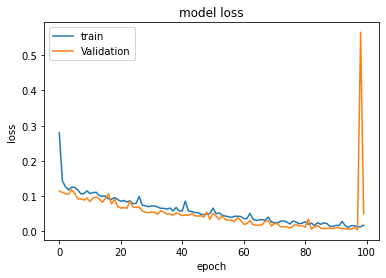

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

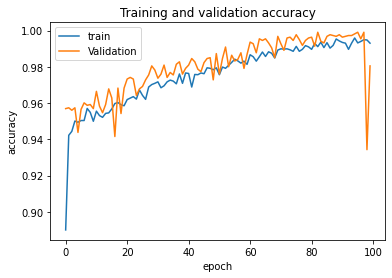

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

[[464   3  29   0   0   0]
 [  1 442  28   0   0   0]
 [  0   0 420   0   0   0]
 [  0   9   0 342 139   1]
 [  0   1   0  17 514   0]
 [  0   0   0   0   0 537]]
0.9226331862911435
0.9212903267454287
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       496
           1       0.97      0.94      0.95       471
           2       0.88      1.00      0.94       420
           3       0.95      0.70      0.80       491
           4       0.79      0.97      0.87       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947



<AxesSubplot:>

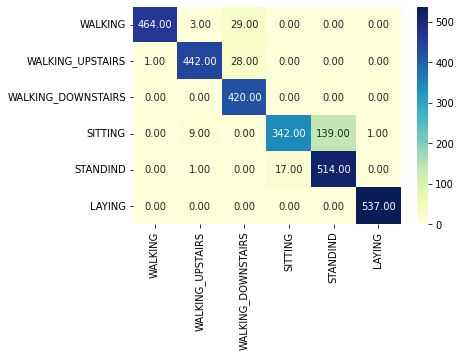

In [41]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [42]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [43]:
import math
import time

start = time.time()
model_history=model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32,validation_data=(X_val,y_val_one_hot))


end = time.time()
print(f"{end - start:.5f} sec")

Epoch 1/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0141 - accuracy: 0.9946 - val_loss: 0.0480 - val_accuracy: 0.9841
Epoch 2/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0114 - accuracy: 0.9949 - val_loss: 0.0103 - val_accuracy: 0.9968
Epoch 3/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0153 - accuracy: 0.9938 - val_loss: 0.0159 - val_accuracy: 0.9950
Epoch 4/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.0221 - val_accuracy: 0.9891
Epoch 5/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0144 - accuracy: 0.9953 - val_loss: 0.0092 - val_accuracy: 0.9946
Epoch 6/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.0109 - val_accuracy: 0.9959
Epoch 7/100
161/161 [==============================] - 3s 17ms/step - loss: 0.0130 - accuracy: 0.9951 - val_loss: 0.0072 - val_accuracy:

161/161 [==============================] - 3s 19ms/step - loss: 0.0202 - accuracy: 0.9949 - val_loss: 0.0538 - val_accuracy: 0.9837
Epoch 58/100
161/161 [==============================] - 3s 18ms/step - loss: 0.0064 - accuracy: 0.9977 - val_loss: 0.0410 - val_accuracy: 0.9900
Epoch 59/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0194 - val_accuracy: 0.9909
Epoch 60/100
161/161 [==============================] - 3s 20ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0314 - val_accuracy: 0.9887
Epoch 61/100
161/161 [==============================] - 3s 20ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0227 - val_accuracy: 0.9905
Epoch 62/100
161/161 [==============================] - 3s 20ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0203 - val_accuracy: 0.9923
Epoch 63/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0164 - val_accuracy: 0.994

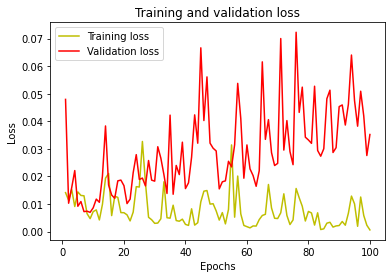

In [44]:
loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

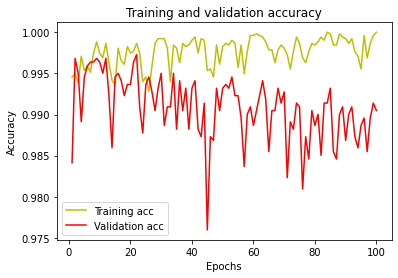

In [45]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[[469   1  26   0   0   0]
 [  0 446  25   0   0   0]
 [  0   0 420   0   0   0]
 [  0   1   0 396  94   0]
 [  0   1   0  14 517   0]
 [  0   0   0   0   0 537]]
0.9450288428910757
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       496
           1       0.99      0.95      0.97       471
           2       0.89      1.00      0.94       420
           3       0.97      0.81      0.88       491
           4       0.85      0.97      0.90       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.94      2947
weighted avg       0.95      0.95      0.94      2947



<AxesSubplot:>

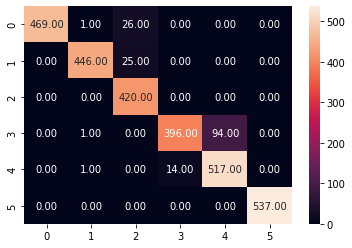

In [46]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy = model.predict(testX)
predy = np.argmax(predy, axis=1)

cm= confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(classification_report(testy,predy))
sns.heatmap(cm, annot=True, fmt = '.2f')

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)